<a href="https://colab.research.google.com/github/alex-smith-uwec/AI_Spring2025/blob/main/FrozenLake_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt


In [53]:

# Initialize FrozenLake environment
env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=True, render_mode=None)
n_actions = env.action_space.n
n_states = env.observation_space.n


In [54]:
def print_frozen_lake_layout(env):
    desc = env.unwrapped.desc.astype(str)
    size = desc.shape[0]

    for i in range(size):
        row = ""
        for j in range(size):
            cell = f" {desc[i][j]} "
            row += f"|{cell}"
        row += "|"
        print(row)
        print("-" * len(row))
print_frozen_lake_layout(env)

| S | F | F | F |
-----------------
| F | H | F | H |
-----------------
| F | F | F | H |
-----------------
| H | F | F | G |
-----------------


In [63]:
# Q-learning parameters
alpha = 0.2  # Learning rate
gamma = 0.95  # Discount factor
epsilon = 0.95  # Initial exploration probability
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 5000


In [56]:

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

# Store rewards per episode
rewards_per_episode = []

# Q-learning loop
for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        # Choose action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(Q[state, :])  # Exploit

        next_state, reward, done, truncated, _ = env.step(action)

        # Update Q-value
        Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (reward + gamma * np.max(Q[next_state, :]))

        state = next_state
        total_reward += reward

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_per_episode.append(total_reward)

    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Epsilon: {epsilon:.4f}, Avg Reward: {np.mean(rewards_per_episode[-100:]):.2f}")


Episode 500/5000, Epsilon: 0.0775, Avg Reward: 0.25
Episode 1000/5000, Epsilon: 0.0100, Avg Reward: 0.73
Episode 1500/5000, Epsilon: 0.0100, Avg Reward: 0.72
Episode 2000/5000, Epsilon: 0.0100, Avg Reward: 0.60
Episode 2500/5000, Epsilon: 0.0100, Avg Reward: 0.64
Episode 3000/5000, Epsilon: 0.0100, Avg Reward: 0.74
Episode 3500/5000, Epsilon: 0.0100, Avg Reward: 0.55
Episode 4000/5000, Epsilon: 0.0100, Avg Reward: 0.68
Episode 4500/5000, Epsilon: 0.0100, Avg Reward: 0.70
Episode 5000/5000, Epsilon: 0.0100, Avg Reward: 0.69


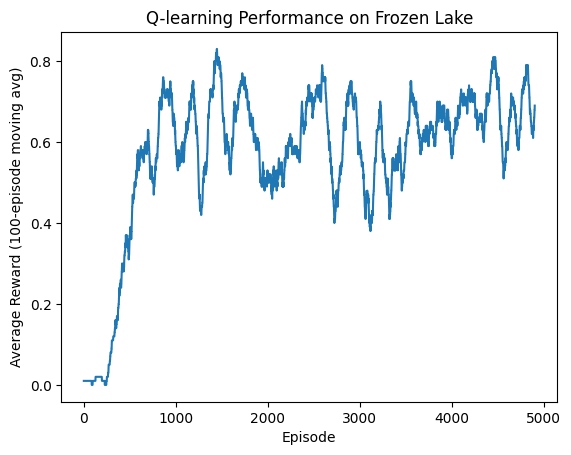

Learned Q-table:
[[0.2650917  0.12816396 0.1421056  0.12257886]
 [0.07074152 0.09068235 0.07533299 0.14561309]
 [0.09260632 0.11365712 0.1009767  0.08444139]
 [0.06992649 0.04217557 0.02626994 0.09271838]
 [0.31392271 0.11570879 0.09705071 0.06169085]
 [0.         0.         0.         0.        ]
 [0.04270968 0.03633461 0.19922588 0.02543891]
 [0.         0.         0.         0.        ]
 [0.19349982 0.16512899 0.12771115 0.3907451 ]
 [0.27379191 0.52697357 0.2045632  0.1947963 ]
 [0.63442115 0.1668846  0.16130052 0.13863328]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.21096324 0.36342089 0.66784135 0.34436903]
 [0.47823015 0.9254722  0.56953387 0.44644811]
 [0.         0.         0.         0.        ]]



Optimal state values from Value Iteration:
[0.18046404 0.15475089 0.15347326 0.13254421 0.20896091 0.
 0.17642894 0.         0.27045289 0.37464883 0.40367096 0.
 0.         0.50897814 0.72367275 0.        ]
State | Max Q-Value 

In [57]:
# Plot learning curve
plt.plot(np.convolve(rewards_per_episode, np.ones(100)/100, mode='valid'))
plt.xlabel("Episode")
plt.ylabel("Average Reward (100-episode moving avg)")
plt.title("Q-learning Performance on Frozen Lake")
plt.show()

# Display learned Q-table
print("Learned Q-table:")
print(Q)

# Value Iteration to find optimal utilities
V = np.zeros(n_states)
threshold = 1e-6
delta = float("inf")
env_unwrapped = env.unwrapped  # Get the raw environment

while delta > threshold:
    delta = 0
    for state in range(n_states):
        v = V[state]
        V[state] = max(sum(prob * (reward + gamma * V[next_state])
                          for prob, next_state, reward, _ in env_unwrapped.P[state][action])
                       for action in range(n_actions))
        delta = max(delta, abs(v - V[state]))

# Display optimal utility values
print("\n\n\nOptimal state values from Value Iteration:")
print(V)

# Compare max Q-values to optimal state values
print("State | Max Q-Value | Optimal V-Value | Difference")
print("---------------------------------------------------")
for state in range(n_states):
    max_q = np.max(Q[state, :])
    optimal_v = V[state]
    diff = abs(max_q - optimal_v)
    print(f"{state:5} | {max_q:10.4f} | {optimal_v:10.4f} | {diff:10.4f}")


In [58]:
# Extract policy from Q-table
policy = np.argmax(Q, axis=1)

# Print the policy
print("Extracted Policy:")
print(policy)

Extracted Policy:
[0 3 1 3 0 0 2 0 3 1 0 0 0 2 1 0]


In [59]:
def visualize_policy(policy, env):
    """Visualizes the policy as a 4x4 grid with arrows.

    Args:
        policy: The policy to visualize (a NumPy array).
        env: The FrozenLake environment.
    """
    desc = env.unwrapped.desc.astype(str)
    size = desc.shape[0]

    for i in range(size):
        row = ""
        for j in range(size):
            cell = f" {desc[i][j]} "
            state = i * size + j

            # Map actions to arrows
            if policy[state] == 0:
                arrow = "←"  # Left
            elif policy[state] == 1:
                arrow = "↓"  # Down
            elif policy[state] == 2:
                arrow = "→"  # Right
            elif policy[state] == 3:
                arrow = "↑"  # Up
            else:
                arrow = " "  # No action

            row += f"|{cell}{arrow}"
        row += "|"
        print(row)
        print("-" * len(row))

# Call the function to visualize the policy
visualize_policy(policy, env)

| S ←| F ↑| F ↓| F ↑|
---------------------
| F ←| H ←| F →| H ←|
---------------------
| F ↑| F ↓| F ←| H ←|
---------------------
| H ←| F →| F ↓| G ←|
---------------------



Average reward per episode using the optimal policy: 0.7790
Average number of steps per episode: 45.02


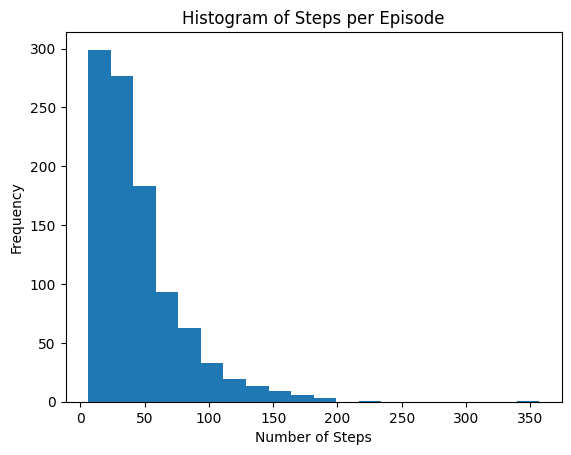

In [60]:




# Simulate average reward per episode using the optimal policy
# In the simulation of average reward, keep track of the number of steps per episode, and make a histogram of the number of steps.

num_simulations = 1000
total_rewards = []
steps_per_episode = []  # Keep track of steps per episode

for _ in range(num_simulations):
    state, _ = env.reset()
    total_reward = 0
    done = False
    steps = 0

    while not done:
        action = policy[state]  # Use the extracted policy
        next_state, reward, done, truncated, _ = env.step(action)
        state = next_state
        total_reward += reward
        steps += 1

    total_rewards.append(total_reward)
    steps_per_episode.append(steps)

average_reward = np.mean(total_rewards)
average_steps = np.mean(steps_per_episode)  # Calculate average steps
print(f"\nAverage reward per episode using the optimal policy: {average_reward:.4f}")
print(f"Average number of steps per episode: {average_steps:.2f}")

# Histogram of number of steps per episode
plt.hist(steps_per_episode, bins=20)
plt.xlabel("Number of Steps")
plt.ylabel("Frequency")
plt.title("Histogram of Steps per Episode")
plt.show()


In [61]:
gamma**44

0.10467395472325501

In [64]:
# Initialize Q-table
Q = np.zeros((n_states, n_actions))
rewards_per_episode = []

for episode in range(num_episodes):
    state, _ = env.reset()
    # Initial action via epsilon-greedy
    if np.random.rand() < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state, :])

    total_reward = 0
    done = False

    while not done:
        next_state, reward, done, truncated, _ = env.step(action)
        # Choose next action via epsilon-greedy
        if np.random.rand() < epsilon:
            next_action = env.action_space.sample()
        else:
            next_action = np.argmax(Q[next_state, :])

        # SARSA update
        Q[state, action] = (1 - alpha) * Q[state, action] + alpha * (
            reward + gamma * Q[next_state, next_action]
        )

        state, action = next_state, next_action
        total_reward += reward

    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards_per_episode.append(total_reward)

    if (episode + 1) % 500 == 0:
        print(f"Episode {episode + 1}/{num_episodes}, Epsilon: {epsilon:.4f}, "
              f"Avg Reward: {np.mean(rewards_per_episode[-100:]):.2f}")


Episode 500/5000, Epsilon: 0.0775, Avg Reward: 0.16
Episode 1000/5000, Epsilon: 0.0100, Avg Reward: 0.43
Episode 1500/5000, Epsilon: 0.0100, Avg Reward: 0.54
Episode 2000/5000, Epsilon: 0.0100, Avg Reward: 0.47
Episode 2500/5000, Epsilon: 0.0100, Avg Reward: 0.73
Episode 3000/5000, Epsilon: 0.0100, Avg Reward: 0.56
Episode 3500/5000, Epsilon: 0.0100, Avg Reward: 0.49
Episode 4000/5000, Epsilon: 0.0100, Avg Reward: 0.78
Episode 4500/5000, Epsilon: 0.0100, Avg Reward: 0.72
Episode 5000/5000, Epsilon: 0.0100, Avg Reward: 0.76
